## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
import rioxarray as rxr
from matplotlib.patches import Rectangle

In [2]:
auth = earthaccess.login()

## 2. Search for Data

In [3]:
tspan = ("2024-04-01", "2025-04-30")
bbox = (113.338953078, -43.6345972634, 153.569469029, -10.6681857235)

In [4]:
results_landvi = earthaccess.search_data(
    short_name="PACE_OCI_L3M_LANDVI",
    temporal=tspan,
    granule_name='*.MO.*0p1deg*',
    bounding_box=bbox
)

Here we will open the datasets.

In [5]:
path_landvi = earthaccess.open(results_landvi)

QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
dataset_landvi = xr.open_mfdataset(path_landvi, combine="nested", concat_dim="date")
dataset_landvi

<xarray.Dataset> Size: 3GB
Dimensions:  (date: 13, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    ndvi     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    evi      (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    ndwi     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    ndii     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cci      (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    ndsi     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    pri      (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cire     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    car      (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    mari     (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 10kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401_20240430.L3m.MO.LAND...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/LANDVI/3.0
    data_bins:                         1554617
    data_minimum:                      -99.69832
    data_maximum:                      155.94499

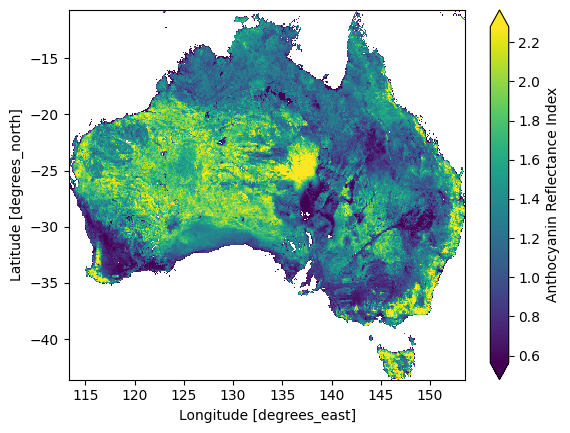

In [7]:
min_lon, max_lat, max_lon, min_lat = bbox
australia = dataset_landvi.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))
plot = australia["mari"][0].plot.imshow(robust=True)


In [8]:
australia["cire"] = australia["cire"].clip(
    min=australia["cire"].attrs["valid_min"],
    max=australia["cire"].attrs["valid_max"],
)
australia["mari"] = australia["mari"].clip(
    min=australia["mari"].attrs["valid_min"],
    max=australia["mari"].attrs["valid_max"],
)
australia["car"] = australia["car"].clip(
    min=australia["car"].attrs["valid_min"],
    max=australia["car"].attrs["valid_max"],
)
australia = australia.drop_vars(['palette'])

### Normalize data

We normalize in order to visualize and compare multiple variables together.

In [9]:
normal_australia = australia.astype(np.float64)
normal_australia = (
    (australia - australia.min())
    / (australia.max() - australia.min())
)
normal_australia = normal_australia.to_dataarray()
normal_australia = normal_australia.sel(variable=["car", "cire", "mari"])
normal_australia

<xarray.DataArray (variable: 3, date: 13, lat: 329, lon: 403)> Size: 21MB
dask.array<getitem, shape=(3, 13, 329, 403), dtype=float32, chunksize=(1, 1, 312, 264), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 1kB -10.75 -10.85 -10.95 ... -43.35 -43.45 -43.55
  * lon       (lon) float32 2kB 113.4 113.5 113.6 113.7 ... 153.4 153.5 153.6
  * variable  (variable) object 24B 'car' 'cire' 'mari'
Dimensions without coordinates: date

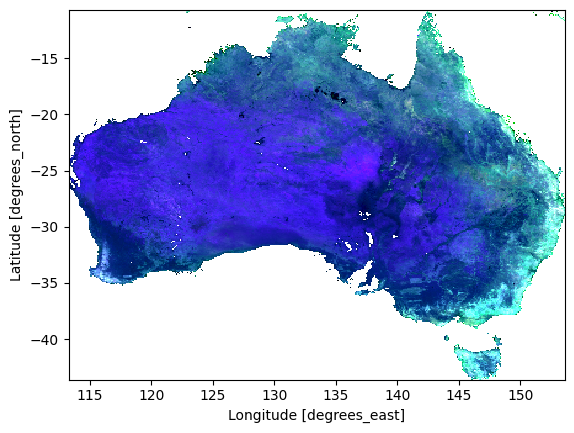

In [12]:
test = normal_australia.sel(date=0)
test.plot.imshow(robust=True)

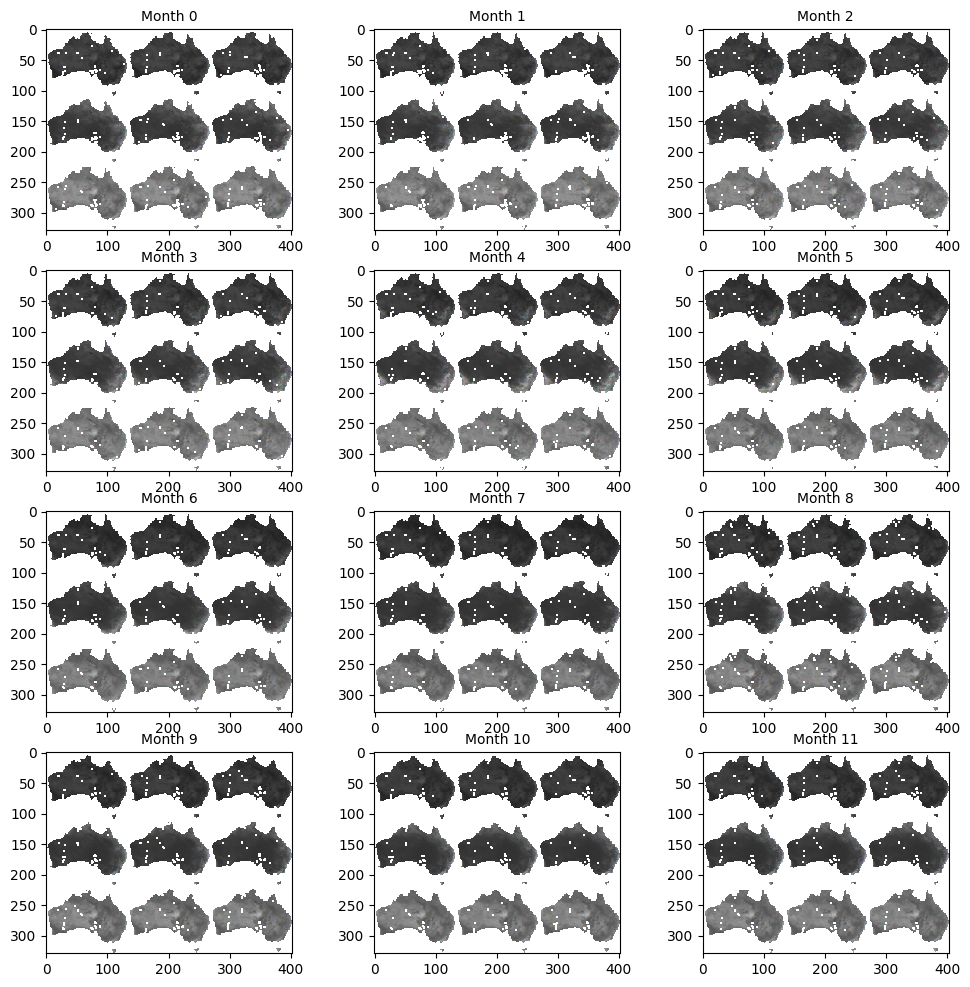

In [39]:
nrows = 4
ncols = 3
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(4 * ncols, 3 * nrows),
    squeeze=False
)
axes_flat = axes.flatten()

# -----------------------------------------------------------------------------
# Loop over each file & axis
# -----------------------------------------------------------------------------
for i, ax in enumerate(axes_flat):
    # Extract stand title from filename
    ds = normal_australia.sel(date=i)
    im = ds.to_numpy().reshape(ds.shape[1], ds.shape[2], 3)
    
    ax.imshow(im)
    ax.set_title(f'Month {i}', fontsize=10)

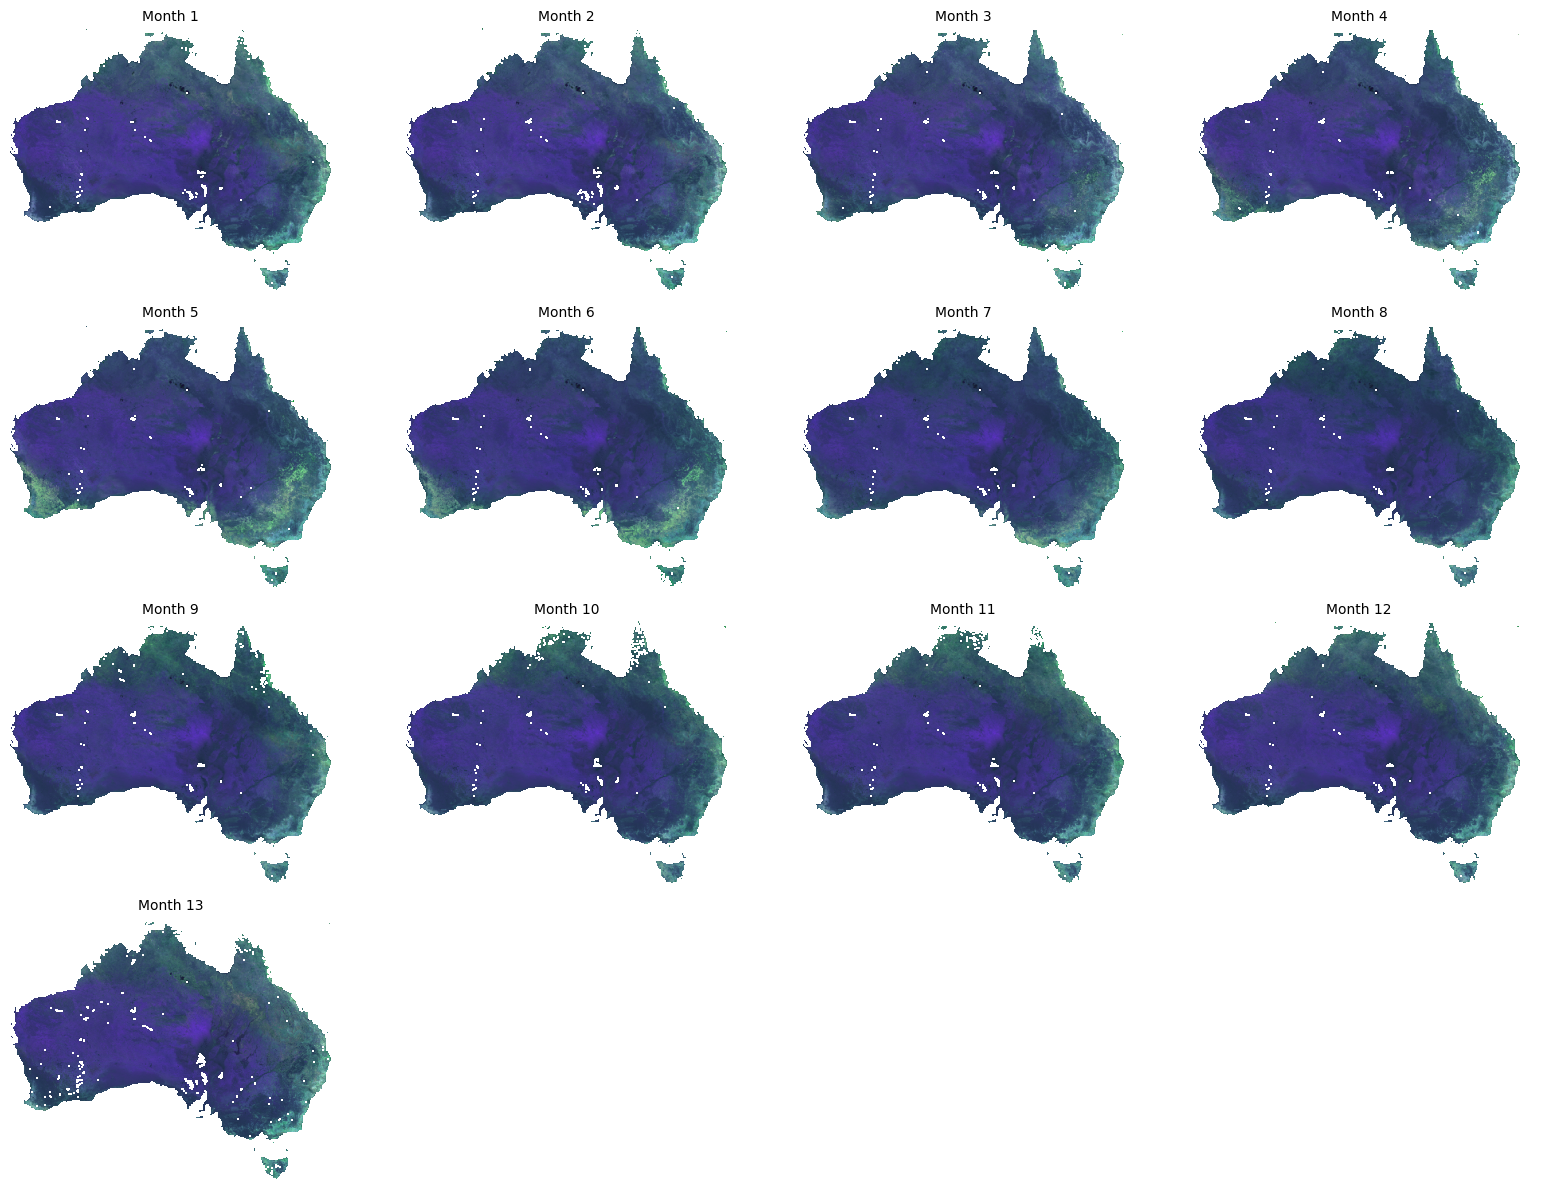

In [40]:
import matplotlib.pyplot as plt

nrows = 4
ncols = 4  # Enough for 13 plots
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), squeeze=False)
axes_flat = axes.flatten()

for i in range(13):  # Loop over your 13 datasets
    ds = normal_australia.sel(date=i)  # shape: (3, 329, 403)

    # Rearrange to shape (329, 403, 3)
    rgb = ds.transpose('lat', 'lon', 'variable').values

    # Normalize if necessary
    if rgb.max() > 1:
        rgb = rgb / 255.0

    ax = axes_flat[i]
    ax.imshow(rgb)
    ax.set_title(f'Month {i + 1}', fontsize=10)
    ax.axis('off')

# Turn off any unused axes
for j in range(13, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()